p 0.46303917401029915
flipped
flipped img shape torch.Size([18, 224, 224])
flipped mask shape torch.Size([1, 224, 224])
mean shape torch.Size([18, 1, 1])
std shape torch.Size([18, 1, 1])
normalized img shape torch.Size([18, 224, 224])
cropped img shape torch.Size([18, 224, 224])
cropped mask shape torch.Size([1, 224, 224])


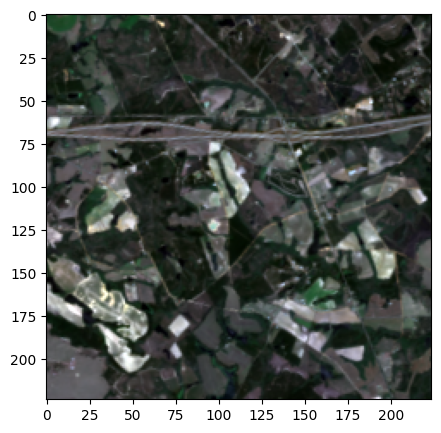

In [55]:
#data_process.py
import torch
import numpy as np
from torch.utils.data import Dataset
import rasterio
import os
import random
import matplotlib.pyplot as plt

img_norm_cfg = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example values
crop_size = (224, 224)  
tile_size = 224 
bands = [0, 1, 2]  
num_frames = 1 

NO_DATA = -9999
NO_DATA_FLOAT = 0.0001
PERCENTILES = (0.1, 99.9)

def load_raster(path,if_img,crop=None):
        with rasterio.open(path) as src:
            img = src.read()

            img = np.where(img == NO_DATA, NO_DATA_FLOAT, img)
            
        return img

def random_crop(tensor, crop_size=(224, 224)):
    # Get original dimensions: channel, height (H), width (W)
    C, H, W = tensor["img"].shape

    # Ensure the crop size fits within the original dimensions
    crop_h, crop_w = crop_size
    if H < crop_h or W < crop_w:
        raise ValueError(f"Original size ({H}, {W}) is smaller than the crop size ({crop_h}, {crop_w})")

    # Randomly select the top-left corner for the crop
    top = random.randint(0, H - crop_h)
    left = random.randint(0, W - crop_w)

    # Perform the crop (channel dimension remains unchanged)
    tensor["img"] = tensor["img"][:, top:top + crop_h, left:left + crop_w]
    tensor["mask"] = tensor["mask"][:,top:top + crop_h, left:left + crop_w]

    return tensor



# Example processing function to simulate the pipeline
def process_input(input_array,mask,img_norm_cfg):
    
    img_tensor = torch.from_numpy(input_array).float()  # Assuming input_array is of type np.float32
    mask_tensor = torch.from_numpy(mask)

    processed_data = {}
    processed_data['img'] = img_tensor  
    processed_data['mask'] = mask_tensor
    
    # step['type'] == "RandomFlip":
    p=np.random.rand()
    print("p",p)
    if p < 0.5:
        print("flipped")
        processed_data['img'] = torch.flip(img_tensor, [2])  # Flip along width
        processed_data['mask'] = torch.flip(mask_tensor, [2])  # Flip along width

    print("flipped img shape",processed_data['img'].shape)
    print("flipped mask shape",processed_data['mask'].shape)

    mean=torch.tensor(img_norm_cfg['mean']).view(-1, 1, 1)
    std=torch.tensor(img_norm_cfg['std']).view(-1, 1, 1)

    print("mean shape",mean.shape)
    print("std shape",std.shape)

    # step['type'] == "TorchNormalize":
    processed_data['img'] = (processed_data['img'] - mean)/ std
    print("normalized img shape",processed_data['img'].shape)

    # step['type'] == "TorchRandomCrop":
    processed_data = random_crop(processed_data, (224, 224))
    print("cropped img shape",processed_data['img'].shape)
    print("cropped mask shape",processed_data['mask'].shape)

    return processed_data

def enhance_raster_for_visualization(raster, ref_img=None):
    if ref_img is None:
        ref_img = raster
    channels = []
    for channel in range(raster.shape[0]):
        valid_mask = np.ones_like(ref_img[channel], dtype=bool)
        valid_mask[ref_img[channel] == NO_DATA_FLOAT] = False
        mins, maxs = np.percentile(ref_img[channel][valid_mask], PERCENTILES)
        normalized_raster = (raster[channel] - mins) / (maxs - mins)
        normalized_raster[~valid_mask] = 0
        clipped = np.clip(normalized_raster, 0, 1)
        channels.append(clipped)
    clipped = np.stack(channels)
    channels_last = np.moveaxis(clipped, 0, -1)[..., :3]
    rgb = channels_last[..., ::-1]
    return rgb


img_path="/rhome/rghosal/crop/validation_chips/chip_304_542_merged.tif"
mask_path="/rhome/rghosal/crop/validation_chips/chip_304_542.mask.tif"

if_img=1
input_array = load_raster(img_path,if_img,crop=None)

if_img=0
mask = load_raster(mask_path,if_img,crop=None)

img_norm_cfg={}
img_norm_cfg["mean"]=[494.905781,815.239594,924.335066,2968.881459,2634.621962,1739.579917,
        494.905781,815.239594,924.335066,2968.881459,2634.621962,1739.579917,
        494.905781,815.239594,924.335066,2968.881459,2634.621962,1739.579917]

img_norm_cfg["std"]=[
        284.925432,
        357.84876,
        575.566823,
        896.601013,
        951.900334,
        921.407808,
        284.925432,
        357.84876,
        575.566823,
        896.601013,
        951.900334,
        921.407808,
        284.925432,
        357.84876,
        575.566823,
        896.601013,
        951.900334,
        921.407808
    ]
processed_data = process_input(input_array,mask,img_norm_cfg)

img=enhance_raster_for_visualization(input_array[:6,:,:], ref_img=None)
mask=enhance_raster_for_visualization(mask, ref_img=None)

plt.figure(figsize=(20,5))
plt.imshow(img)
plt.show()



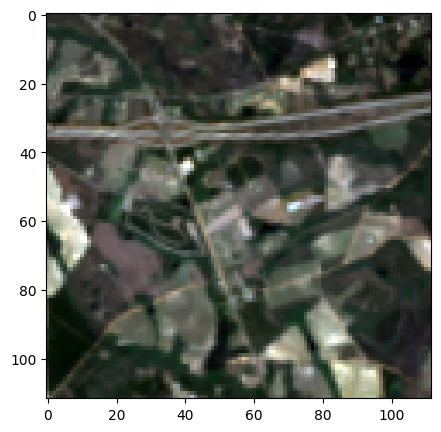

In [53]:
img_aug=enhance_raster_for_visualization(processed_data["img"], ref_img=None)
mask_aug=enhance_raster_for_visualization(processed_data["mask"], ref_img=None)
plt.figure(figsize=(20,5))
plt.imshow(img_aug)
plt.show()

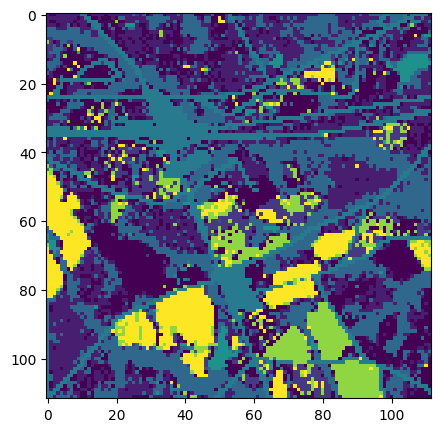

In [54]:
mask_aug=enhance_raster_for_visualization(processed_data["mask"], ref_img=None)
plt.figure(figsize=(20,5))
plt.imshow(mask_aug)
plt.show()